In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/FANG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,19.459999,19.920000,18.600000,19.240000,18.924437,189700
1,1/3/2013,19.240000,19.459999,18.650000,19.139999,18.826073,89100
2,1/4/2013,19.250000,20.490000,18.969999,20.049999,19.721148,173300
3,1/7/2013,19.889999,21.240000,19.639999,20.770000,20.429340,210300
4,1/8/2013,20.690001,21.100000,20.379999,20.600000,20.262127,229400


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 6382.719973.3, cost: -4482.711914, total money: 127.529966
epoch: 20, total rewards: 5973.010019.3, cost: -5951.742676, total money: 195.019979
epoch: 30, total rewards: 6082.020077.3, cost: -7782.387207, total money: 336.170055
epoch: 40, total rewards: 4012.970076.3, cost: -12856.530273, total money: 276.330091
epoch: 50, total rewards: 3370.310103.3, cost: -15143.516602, total money: 281.190130
epoch: 60, total rewards: 2774.130122.3, cost: -16731.652344, total money: 198.350123
epoch: 70, total rewards: 1740.220136.3, cost: -18916.248047, total money: 194.880139
epoch: 80, total rewards: 965.160174.3, cost: -19776.628906, total money: 191.910174
epoch: 90, total rewards: 254.750149.3, cost: -24192.091797, total money: 2477.090138
epoch: 100, total rewards: -351.839927.3, cost: -27375.687500, total money: 5824.190057
epoch: 110, total rewards: -584.219977.3, cost: -27733.466797, total money: 6795.220002
epoch: 120, total rewards: 37.600059.3, cost: -29868.2

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 7: buy 1 unit at price 21.670000, total balance 9978.330000
day 8: buy 1 unit at price 21.799999, total balance 9956.530001
day 9: buy 1 unit at price 21.719999, total balance 9934.810001
day 10: buy 1 unit at price 21.280001, total balance 9913.530001
day 11, sell 1 unit at price 21.120001, investment -2.538068 %, total balance 9934.650002,
day 16, sell 1 unit at price 22.000000, investment 0.917435 %, total balance 9956.650002,
day 18: buy 1 unit at price 22.129999, total balance 9934.520002
day 19: buy 1 unit at price 22.670000, total balance 9911.850002
day 20, sell 1 unit at price 22.420000, investment 3.222840 %, total balance 9934.270002,
day 21, sell 1 unit at price 22.700001, investment 6.672932 %, total balance 9956.970003,
day 23: buy 1 unit at price 22.629999, total balance 9934.340004
day 24: buy 1 unit at price 22.629999, total balance 9911.710005
day 25, sell 1 unit at price 22.420000, investment 1.310443 %, total balance 9934.130005,
day 27: buy 1 unit at price 21.5

day 295: buy 1 unit at price 62.759998, total balance 9892.560001
day 296: buy 1 unit at price 63.880001, total balance 9828.680000
day 299: buy 1 unit at price 63.160000, total balance 9765.520001
day 302, sell 1 unit at price 63.930000, investment 8.558331 %, total balance 9829.450001,
day 304, sell 1 unit at price 64.400002, investment 7.963118 %, total balance 9893.850002,
day 305, sell 1 unit at price 65.190002, investment 0.601851 %, total balance 9959.040005,
day 307: buy 1 unit at price 64.139999, total balance 9894.900005
day 310: buy 1 unit at price 68.040001, total balance 9826.860004
day 311, sell 1 unit at price 69.699997, investment 6.444706 %, total balance 9896.560001,
day 312, sell 1 unit at price 67.309998, investment 5.106178 %, total balance 9963.869999,
day 314, sell 1 unit at price 68.970001, investment 9.894842 %, total balance 10032.840000,
day 316: buy 1 unit at price 67.250000, total balance 9965.590000
day 317: buy 1 unit at price 65.169998, total balance 990

day 466, sell 1 unit at price 65.820000, investment -9.983592 %, total balance 9857.760021,
day 467, sell 1 unit at price 69.489998, investment 0.317600 %, total balance 9927.250019,
day 470, sell 1 unit at price 64.809998, investment 10.900067 %, total balance 9992.060017,
day 471: buy 1 unit at price 64.760002, total balance 9927.300015
day 472: buy 1 unit at price 67.790001, total balance 9859.510014
day 476, sell 1 unit at price 67.209999, investment 6.479722 %, total balance 9926.720013,
day 477: buy 1 unit at price 69.739998, total balance 9856.980015
day 478: buy 1 unit at price 68.089996, total balance 9788.890018
day 479: buy 1 unit at price 67.029999, total balance 9721.860020
day 482, sell 1 unit at price 55.810001, investment -13.176723 %, total balance 9777.670021,
day 484, sell 1 unit at price 59.860001, investment -6.658345 %, total balance 9837.530022,
day 486: buy 1 unit at price 58.790001, total balance 9778.740021
day 487: buy 1 unit at price 54.799999, total balance

day 645: buy 1 unit at price 63.299999, total balance 9468.060036
day 646, sell 1 unit at price 64.989998, investment -14.923421 %, total balance 9533.050034,
day 647, sell 1 unit at price 67.650002, investment -10.099666 %, total balance 9600.700035,
day 649: buy 1 unit at price 67.300003, total balance 9533.400032
day 650, sell 1 unit at price 66.820000, investment -11.096333 %, total balance 9600.220032,
day 651, sell 1 unit at price 67.989998, investment -9.803661 %, total balance 9668.210030,
day 654, sell 1 unit at price 68.839996, investment -5.465536 %, total balance 9737.050026,
day 655, sell 1 unit at price 70.190002, investment -4.020231 %, total balance 9807.240028,
day 657: buy 1 unit at price 72.480003, total balance 9734.760025
day 658: buy 1 unit at price 71.669998, total balance 9663.090027
day 659: buy 1 unit at price 73.900002, total balance 9589.190025
day 660, sell 1 unit at price 72.209999, investment 4.214170 %, total balance 9661.400024,
day 661, sell 1 unit at 

day 808: buy 1 unit at price 77.620003, total balance 9076.120037
day 809: buy 1 unit at price 78.050003, total balance 8998.070034
day 811: buy 1 unit at price 76.699997, total balance 8921.370037
day 812, sell 1 unit at price 77.430000, investment 6.374501 %, total balance 8998.800037,
day 813, sell 1 unit at price 76.459999, investment 1.204495 %, total balance 9075.260036,
day 814: buy 1 unit at price 77.160004, total balance 8998.100033
day 815: buy 1 unit at price 79.029999, total balance 8919.070034
day 816, sell 1 unit at price 77.180000, investment 6.308543 %, total balance 8996.250034,
day 817: buy 1 unit at price 76.769997, total balance 8919.480038
day 818, sell 1 unit at price 74.510002, investment 4.575442 %, total balance 8993.990040,
day 819, sell 1 unit at price 73.800003, investment -1.442300 %, total balance 9067.790043,
day 821, sell 1 unit at price 79.070000, investment 9.819444 %, total balance 9146.860043,
day 822, sell 1 unit at price 81.050003, investment 20.41

day 1068: buy 1 unit at price 102.669998, total balance 8086.360081
day 1071, sell 1 unit at price 106.769997, investment 5.650108 %, total balance 8193.130078,
day 1073: buy 1 unit at price 104.669998, total balance 8088.460080
day 1074: buy 1 unit at price 104.379997, total balance 7984.080082
day 1075, sell 1 unit at price 104.620003, investment 3.145028 %, total balance 8088.700085,
day 1077: buy 1 unit at price 106.320000, total balance 7982.380085
day 1078: buy 1 unit at price 105.040001, total balance 7877.340084
day 1079: buy 1 unit at price 105.139999, total balance 7772.200085
day 1082: buy 1 unit at price 100.269997, total balance 7671.930088
day 1084: buy 1 unit at price 101.760002, total balance 7570.170086
day 1086, sell 1 unit at price 103.209999, investment -0.673664 %, total balance 7673.380085,
day 1087: buy 1 unit at price 100.449997, total balance 7572.930088
day 1088: buy 1 unit at price 99.839996, total balance 7473.090092
day 1089, sell 1 unit at price 98.959999,

day 1253, sell 1 unit at price 123.099998, investment 27.472299 %, total balance 7878.310108,
day 1255, sell 1 unit at price 125.970001, investment 30.336264 %, total balance 8004.280110,
day 1256, sell 1 unit at price 123.190002, investment 28.483527 %, total balance 8127.470112,
day 1257, sell 1 unit at price 125.519997, investment 31.834889 %, total balance 8252.990109,
day 1259: buy 1 unit at price 127.879997, total balance 8125.110111
day 1260, sell 1 unit at price 129.169998, investment 44.939401 %, total balance 8254.280110,
day 1261, sell 1 unit at price 130.130005, investment 47.824613 %, total balance 8384.410114,
day 1265: buy 1 unit at price 127.290001, total balance 8257.120114
day 1268: buy 1 unit at price 128.020004, total balance 8129.100109
day 1269, sell 1 unit at price 127.440002, investment 44.538965 %, total balance 8256.540112,
day 1271, sell 1 unit at price 127.570000, investment 40.511068 %, total balance 8384.110111,
day 1277: buy 1 unit at price 129.050003, to

day 1439: buy 1 unit at price 128.580002, total balance 6356.260083
day 1440: buy 1 unit at price 126.720001, total balance 6229.540082
day 1441, sell 1 unit at price 128.550003, investment -0.487684 %, total balance 6358.090085,
day 1442: buy 1 unit at price 132.860001, total balance 6225.230084
day 1443, sell 1 unit at price 134.509995, investment 9.732414 %, total balance 6359.740079,
day 1444: buy 1 unit at price 131.330002, total balance 6228.410077
day 1446: buy 1 unit at price 135.190002, total balance 6093.220074
day 1448, sell 1 unit at price 137.050003, investment 17.801279 %, total balance 6230.270078,
day 1449: buy 1 unit at price 139.919998, total balance 6090.350079
day 1450: buy 1 unit at price 135.250000, total balance 5955.100079
day 1451: buy 1 unit at price 136.350006, total balance 5818.750073
day 1453, sell 1 unit at price 135.130005, investment 4.849472 %, total balance 5953.880078,
day 1454, sell 1 unit at price 129.279999, investment 1.899579 %, total balance 60

day 1590, sell 1 unit at price 106.900002, investment -17.458107 %, total balance 5817.570088,
day 1591, sell 1 unit at price 106.389999, investment -16.201953 %, total balance 5923.960087,
day 1593: buy 1 unit at price 99.120003, total balance 5824.840084
day 1594: buy 1 unit at price 100.470001, total balance 5724.370083
day 1595: buy 1 unit at price 100.699997, total balance 5623.670086
day 1596, sell 1 unit at price 98.230003, investment -21.138403 %, total balance 5721.900090,
day 1597: buy 1 unit at price 105.849998, total balance 5616.050091
day 1601, sell 1 unit at price 109.110001, investment -8.395601 %, total balance 5725.160092,
day 1602, sell 1 unit at price 109.059998, investment -0.746268 %, total balance 5834.220089,
day 1603: buy 1 unit at price 110.629997, total balance 5723.590092
day 1605: buy 1 unit at price 109.660004, total balance 5613.930088
day 1606, sell 1 unit at price 113.800003, investment 1.281597 %, total balance 5727.730091,
day 1608, sell 1 unit at pri

day 1753, sell 1 unit at price 87.080002, investment -9.404911 %, total balance 5667.270055,
day 1757, sell 1 unit at price 90.180000, investment -7.583523 %, total balance 5757.450055,
day 1758, sell 1 unit at price 91.309998, investment -12.655446 %, total balance 5848.760052,


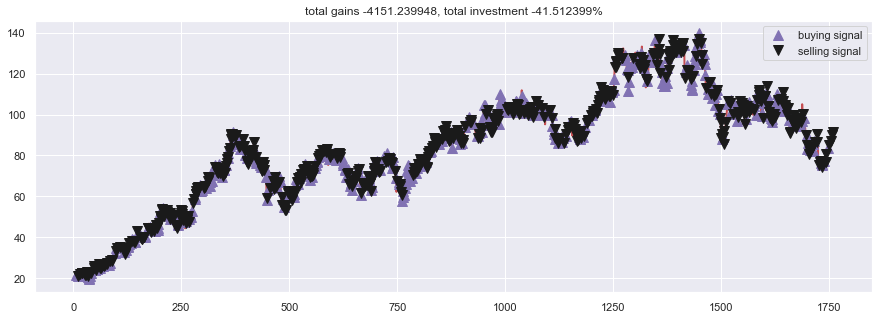

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()